In [1]:
# tf tools
import tensorflow as tf

# image processsing
from tensorflow.keras.preprocessing.image import (load_img,
                                                  img_to_array,
                                                  ImageDataGenerator)
# VGG16 model
from tensorflow.keras.applications.vgg16 import (preprocess_input,
                                                 decode_predictions,
                                                 VGG16)
# cifar10 data - 32x32
from tensorflow.keras.datasets import cifar10

# layers
from tensorflow.keras.layers import (Flatten, 
                                     Dense, 
                                     Dropout, 
                                     BatchNormalization)
# generic model object
from tensorflow.keras.models import Model

# optimizers
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import SGD

#scikit-learn
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report

# for plotting
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

2023-04-17 15:20:55.306493: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


- LOad images in with specific size 
- create modal with input size 
- maybe normalise images 
- binarize labels.

# Json FIles

In [14]:
test_metadata = pd.read_json(os.path.join("..", "..", "..", "images", "metadata", "test_data.json"), lines=True)
train_metadata = pd.read_json(os.path.join("..", "..", "..", "images", "metadata", "train_data.json"), lines=True)
val_metadata = pd.read_json(os.path.join("..", "..", "..", "images", "metadata", "val_data.json"), lines=True)

In [41]:
train_metadata

,image_url,image_path,brand,product_title,class_label,color
0,https://m.media-amazon.com/images/I/81XKaSKvly...,images/train/0.jpeg,Womanista,Women's Georgette Saree with Blouse Piece (TKI...,saree,NaN
1,https://m.media-amazon.com/images/I/91dDMDg+QT...,images/train/1.jpeg,Yashika,Women Linen Printed Sarees Free Size (BEE),saree,NaN
2,https://m.media-amazon.com/images/I/71TJ9p46PV...,images/train/2.jpeg,Womanista,Organza Floral Print Saree with Blouse Piece(W...,saree,NaN
3,https://m.media-amazon.com/images/I/81Y+je7CEg...,images/train/3.jpeg,PERFECTBLUE,Women's Digital Cotton Linen Blend Saree with ...,saree,NaN
4,https://m.media-amazon.com/images/I/61B8o9Ulqp...,images/train/4.jpeg,VAIVIDHYAM,Designer Sarees Women's Banarasi Cotton Silk S...,saree,NaN
...,...,...,...,...,...,...
91161,https://rukminim1.flixcart.com/image/309/371/k...,images/train/91161.jpeg,AURELIA,Women Printed Pure Cotton Straight Kurta,women_kurta,Blue
91162,https://rukminim1.flixcart.com/image/309/371/k...,images/train/91162.jpeg,Prime clothing,Women Checkered Cotton Blend Straight Kurta,women_kurta,White
91163,https://rukminim1.flixcart.com/image/309/371/k...,images/train/91163.jpeg,Vrisa,Women Embroidered Georgette Straight Kurta,women_kurta,White
91164,https://rukminim1.flixcart.com/image/309/371/k...,images/train/91164.jpeg,HELLEN VELLEN,Women Printed Rayon A-line Kurta,women_kurta,Dark Blue


# Importing a test image 

In [4]:
# load an image from file
image = load_img(os.path.join("..", "..", "..", "images", "train", "10.jpeg"), target_size=(320, 320)) # Specifying pixal size of 224 x 244

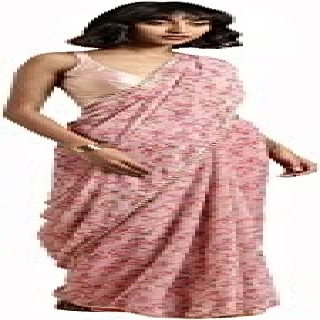

In [5]:
image

In [28]:
image = img_to_array(image)

In [29]:
image.shape #320, 89

(320, 200, 3)

# Data generator 

## Specifying dir for train and test

In [57]:
# flip along x axis (mirror image)
# Data augmentaion 
# ImageDataGenerator from tensorflow 
datagen = ImageDataGenerator(horizontal_flip=True, # Flip it horizontally around the access
                             rotation_range=20, # Rotate the image randomly 20 degress around the access
                             rescale = 1/255) # Take 10 % for validation
# Take your images, create a pipelie (Take an image modify it, pass it on)


In [49]:
directory_train = os.path.join("..","..","..", "images", "train")
directory_validation = os.path.join("..","..","..", "images", "val")

In [48]:
label_train = train_metadata["class_label"].tolist() # Making column class-Label to a list 
label_val = val_metadata["class_label"].tolist()


# train

In [61]:
X_train_tf = tf.keras.preprocessing.image_dataset_from_directory(
    directory_train,
    labels= label_train,
    #label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=128,
    image_size=(320, 320),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 91166 files belonging to 15 classes.


# Validation

In [52]:
validation = tf.keras.preprocessing.image_dataset_from_directory(
    directory_validation,
    labels= label_val,
    #label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=128,
    image_size=(320, 320),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 7500 files belonging to 15 classes.


In [56]:
class_names = validation.class_names
print(class_names)

['blouse', 'dhoti_pants', 'dupattas', 'gowns', 'kurta_men', 'leggings_and_salwars', 'lehenga', 'mojaris_men', 'mojaris_women', 'nehru_jackets', 'palazzos', 'petticoats', 'saree', 'sherwanis', 'women_kurta']


# Model

In [53]:
# load model without classifier layers
model = VGG16(include_top=False, 
              pooling='avg',
              input_shape=(320, 320, 3))

# mark loaded layers as not trainable
for layer in model.layers:
    layer.trainable = False
    
# add new classifier layers
flat1 = Flatten()(model.layers[-1].output)
bn = BatchNormalization()(flat1) # Added batnormalization from tensorflow. Take the previouslayer, normalise the values, and than pass them on
class1 = Dense(256, 
               activation='relu')(bn) # Added new classification layer 
class2 = Dense(128, 
               activation='relu')(class1)
output = Dense(10, 
               activation='softmax')(class2)

# define new model
model = Model(inputs=model.inputs, 
              outputs=output)

# compile
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=10000,
    decay_rate=0.9)
sgd = SGD(learning_rate=lr_schedule)

model.compile(optimizer=sgd,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
# summarize
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 320, 320, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 320, 320, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 320, 320, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 160, 160, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 160, 160, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 160, 160, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 80, 80, 128)       0   

## Transform to numpy array

In [66]:
X_train = np.array(list(X_train_tf.as_numpy_iterator()))

/tmp/ipykernel_612/3346912217.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_train = np.array(list(X_train_tf.as_numpy_iterator()))


In [64]:
X_val = np.array(list(validation.as_numpy_iterator()))

2023-04-17 17:20:02.892318: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype string and shape [7500]
	 [[{{node Placeholder/_4}}]]
2023-04-17 17:20:02.893066: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype string and shape [7500]
	 [[{{node Placeholder/_4}}]]
/tmp/ipykernel_612/3298968181.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_val = 

#### remove label from array

In [71]:
X_train, y_train = zip(*X_train)
X_train = np.array(X_train)
y_train = np.array(y_train)

X_val, y_val = zip(*X_val)
X_val = np.array(X_val)
y_val = np.array(y_val)


[array([b'blouse', b'sherwanis', b'leggings_and_salwars', b'gowns',
        b'dupattas', b'women_kurta', b'sherwanis', b'lehenga', b'palazzos',
        b'palazzos', b'blouse', b'kurta_men', b'leggings_and_salwars',
        b'women_kurta', b'petticoats', b'petticoats', b'gowns', b'gowns',
        b'leggings_and_salwars', b'petticoats', b'kurta_men',
        b'mojaris_women', b'women_kurta', b'saree', b'mojaris_men',
        b'mojaris_men', b'dhoti_pants', b'dhoti_pants', b'petticoats',
        b'nehru_jackets', b'palazzos', b'palazzos', b'dupattas',
        b'leggings_and_salwars', b'leggings_and_salwars', b'nehru_jackets',
        b'sherwanis', b'petticoats', b'kurta_men', b'dupattas',
        b'leggings_and_salwars', b'kurta_men', b'kurta_men', b'lehenga',
        b'dhoti_pants', b'gowns', b'lehenga', b'women_kurta', b'blouse',
        b'palazzos', b'leggings_and_salwars', b'palazzos', b'kurta_men',
        b'blouse', b'dhoti_pants', b'petticoats', b'mojaris_women',
        b'blouse',

### Train model

In [73]:
# fit the data generator to our images
datagen.fit(X_train) # Fit the training data to our data augmentation 
datagen.fit(X_val)
# fits the model on batches with real-time data augmentation:
H = model.fit(datagen.flow(X_train, y_train, batch_size=128, subset = "training"), # Creating a flow -- take the original images, some get modifyied. 
              validation_data = datagen.flow(X_val, y_val, batch_size=128, subset = "validation"),
            epochs=1) # change to 10


# Possible to get image (stream the image) (stream it frow the dataGenerator) from the folder, instead of loading the image into the script. 

ValueError: setting an array element with a sequence.